# Creating Customer Segments

## Getting Started

In this project, you will analyze a dataset containing data on various customers' annual spending amounts (reported in *monetary units*) of diverse product categories for internal structure. One goal of this project is to best describe the variation in the different types of customers that a wholesale distributor interacts with. Doing so would equip the distributor with insight into how to best structure their delivery service to meet the needs of each customer.

The dataset for this project can be found on the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers). For the purposes of this project, the features `'Channel'` and `'Region'` will be excluded in the analysis — with focus instead on the six product categories recorded for customers.

Run the code block below to load the wholesale customers dataset, along with a few of the necessary Python libraries required for this project. You will know the dataset loaded successfully if the size of the dataset is reported.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import pandas as pd
import numpy as np

from IPython.display import display # Allows the use of display() for DataFrames

# Show matplotlib plots inline (nicely formatted in the notebook)
%matplotlib inline
sns.set()

# Load the wholesale customers dataset
try:
    data = pd.read_csv("customers.csv")
    data.drop(['Region', 'Channel'], axis = 1, inplace = True)
    print("Wholesale customers dataset has {} samples with {} features each.".format(*data.shape))
except:
    print("Dataset could not be loaded. Is the dataset missing?")

Wholesale customers dataset has 440 samples with 6 features each.


In [2]:
from sklearn.decomposition import PCA as pca

def pca_results(good_data, pca):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''

    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = good_data.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (14,8))

    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=0)


    # Display the explained variance ratios
    for i, ev in enumerate(pca.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

def cluster_results(reduced_data, preds, centers, pca_samples):
    '''
    Visualizes the PCA-reduced cluster data in two dimensions
    Adds cues for cluster centers and student-selected sample data
    '''

    predictions = pd.DataFrame(preds, columns = ['Cluster'])
    plot_data = pd.concat([predictions, reduced_data], axis = 1)

    # Generate the cluster plot
    fig, ax = plt.subplots(figsize = (14,8))

    # Color map
    cmap = cm.get_cmap('gist_rainbow')

    # Color the points based on assigned cluster
    for i, cluster in plot_data.groupby('Cluster'):   
        cluster.plot(ax = ax, kind = 'scatter', x = 'Dimension 1', y = 'Dimension 2', \
                     color = cmap((i)*1.0/(len(centers)-1)), label = 'Cluster %i'%(i), s=30);

    # Plot centers with indicators
    for i, c in enumerate(centers):
        ax.scatter(x = c[0], y = c[1], color = 'white', edgecolors = 'black', \
                   alpha = 1, linewidth = 2, marker = 'o', s=200);
        ax.scatter(x = c[0], y = c[1], marker='$%d$'%(i), alpha = 1, s=100);

    # Plot transformed sample points 
    ax.scatter(x = pca_samples[:,0], y = pca_samples[:,1], \
               s = 150, linewidth = 4, color = 'black', marker = 'x');

    # Set plot title
    ax.set_title("Cluster Learning on PCA-Reduced Data - Centroids Marked by Number\nTransformed Sample Data Marked by Black Cross");


def channel_results(reduced_data, outliers, pca_samples):
    '''
    Visualizes the PCA-reduced cluster data in two dimensions using the full dataset
    Data is labeled by "Channel" and cues added for student-selected sample data
    '''

    # Check that the dataset is loadable
    try:
        full_data = pd.read_csv("customers.csv")
    except:
        print("Dataset could not be loaded. Is the file missing?")
        return False

    # Create the Channel DataFrame
    channel = pd.DataFrame(full_data['Channel'], columns = ['Channel'])
    channel = channel.drop(channel.index[outliers]).reset_index(drop = True)
    labeled = pd.concat([reduced_data, channel], axis = 1)

    # Generate the cluster plot
    fig, ax = plt.subplots(figsize = (14,8))

    # Color map
    cmap = cm.get_cmap('gist_rainbow')

    # Color the points based on assigned Channel
    labels = ['Hotel/Restaurant/Cafe', 'Retailer']
    grouped = labeled.groupby('Channel')
    for i, channel in grouped:   
        channel.plot(ax = ax, kind = 'scatter', x = 'Dimension 1', y = 'Dimension 2', \
                     color = cmap((i-1)*1.0/2), label = labels[i-1], s=30);

    # Plot transformed sample points   
    for i, sample in enumerate(pca_samples):
        ax.scatter(x = sample[0], y = sample[1], \
               s = 200, linewidth = 3, color = 'black', marker = 'o', facecolors = 'none');
        ax.scatter(x = sample[0]+0.25, y = sample[1]+0.3, marker='$%d$'%(i), alpha = 1, s=125);

    # Set plot title
    ax.set_title("PCA-Reduced Data Labeled by 'Channel'\nTransformed Sample Data Circled");

## Data Exploration
In this section, you will begin exploring the data through visualizations and code to understand how each feature is related to the others. You will observe a statistical description of the dataset, consider the relevance of each feature, and select a few sample data points from the dataset which you will track through the course of this project.

Run the code block below to observe a statistical description of the dataset. Note that the dataset is composed of six important product categories: **'Fresh'**, **'Milk'**, **'Grocery'**, **'Frozen'**, **'Detergents_Paper'**, and **'Delicatessen'**. Consider what each category represents in terms of products you could purchase.

In [3]:
# Display a description of the dataset
display(data.describe())

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


### Implementation: Selecting Samples
To get a better understanding of the customers and how their data will transform through the analysis, it would be best to select a few sample data points and explore them in more detail. In the code block below, add **three** indices of your choice to the `indices` list which will represent the customers to track. It is suggested to try different sets of samples until you obtain customers that vary significantly from one another.

In [4]:
# TODO: Select three indices of your choice you wish to sample from the dataset
indices = [23,87,200]

# Create a DataFrame of the chosen samples
samples = pd.DataFrame(data.loc[indices], columns = data.keys()).reset_index(drop = True)
print("Chosen samples of wholesale customers dataset:")
display(samples)

Chosen samples of wholesale customers dataset:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,26373,36423,22019,5154,4337,16523
1,43265,5025,8117,6312,1579,14351
2,3067,13240,23127,3941,9959,731


### Question 1
Consider the total purchase cost of each product category and the statistical description of the dataset above for your sample customers.  
*What kind of establishment (customer) could each of the three samples you've chosen represent?*  
**Hint:** Examples of establishments include places like markets, cafes, and retailers, among many others. Avoid using names for establishments, such as saying *"McDonalds"* when describing a sample customer as a restaurant.

**Answer:** The first thing that stands out from the statistical description of the dataset is that there are some customers with very high annual spends which likely pulls the mean higher. Median (50%) spending is probably a better gauge of typical customer. 
- Customer[23] is over the 75% quartile all categories, but delicatessen and milk purchases are particularly large compared to the median mix. Maybe this customer is a multi-location convenience store with grab-and-go food and coffee/smoothies. 
- Customer[87] also has large delicatessen purchases, but a much smaller mix of milk and general groceries. Fresh foods also represent a large category. Perhaps they are a cafes with offerings focused on salads and deli sandwiches. 
- Customer[200] has a fairly low spend on fresh and delicatessen categories. They have a much higher percentage of grocery and detergents/paper. Maybe this is an industrial customer like a school that focuses on food with longer shelf life (less fresh) and needs substantial paper products.

Although a comparison with between the sample points and the statistical description yields some insight, a visual representation might be clearer. 

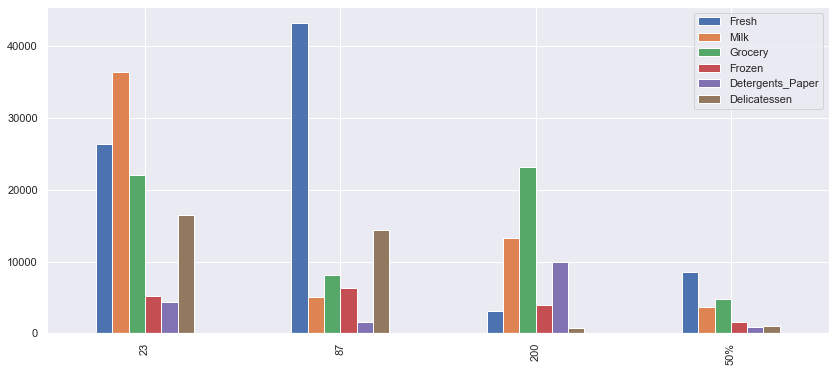

In [5]:
samples_bar = samples.append(data.describe().loc['50%'])
samples_bar.index = indices + ['50%']
_ = samples_bar.plot(kind='bar', figsize=(14,6))

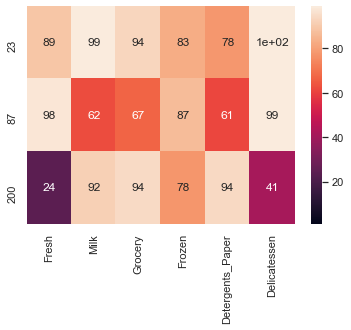

In [6]:
# First, calculate the percentile ranks of the whole dataset.
percentiles = data.rank(pct=True)
# Then, round it up, and multiply by 100
percentiles = 100*percentiles.round(decimals=3)
# Select the indices you chose from the percentiles dataframe
percentiles = percentiles.iloc[indices]
# Now, create the heat map using the seaborn library
_ = sns.heatmap(percentiles, vmin=1, vmax=99, annot=True)

Both of these data visualizations illustrate the sample data points and in which categories they have unusually high or low spending.

### Implementation: Feature Relevance
One interesting thought to consider is if one (or more) of the six product categories is actually relevant for understanding customer purchasing. That is to say, is it possible to determine whether customers purchasing some amount of one category of products will necessarily purchase some proportional amount of another category of products? We can make this determination quite easily by training a supervised regression learner on a subset of the data with one feature removed, and then score how well that model can predict the removed feature.

In the code block below, you will need to implement the following:
 - Assign `new_data` a copy of the data by removing a feature of your choice using the `DataFrame.drop` function.
 - Use `sklearn.model_selection.train_test_split` to split the dataset into training and testing sets.
   - Use the removed feature as your target label. Set a `test_size` of `0.25` and set a `random_state`.
 - Import a decision tree regressor, set a `random_state`, and fit the learner to the training data.
 - Report the prediction score of the testing set using the regressor's `score` function.

In [7]:
# TODO: Make a copy of the DataFrame, using the 'drop' function to drop the given feature
new_data = data.drop('Grocery', axis = 1)
label = data['Grocery']

# TODO: Split the data into training and testing sets using the given feature as the target
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(new_data, label, test_size=0.25, random_state=123)

# TODO: Create a decision tree regressor and fit it to the training set
from sklearn import tree
clf = tree.DecisionTreeRegressor(random_state=123)
regressor = clf.fit(X_train,y_train)

# TODO: Report the score of the prediction using the testing set
score = clf.score(X_test,y_test)
print(score)

0.7511903888523016


### Question 2
*Which feature did you attempt to predict? What was the reported prediction score? Is this feature is necessary for identifying customers' spending habits?*  
**Hint:** The coefficient of determination, `R^2`, is scored between 0 and 1, with 1 being a perfect fit. A negative `R^2` implies the model fails to fit the data.

**Answer:** We attempted to predict the category "Grocery". The reported prediction score was .7512, indicating a correlation with at least one of the features (other categories). Therefore, the "Grocery" feature may not be necessary for identifying customers' spending habits.

Exact correlations can be obtained with data.corr()

In [8]:
data.corr()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Fresh,1.000000,0.100510,-0.011854,0.345881,-0.101953,0.244690
Milk,0.100510,1.000000,0.728335,0.123994,0.661816,0.406368
Grocery,-0.011854,0.728335,1.000000,-0.040193,0.924641,0.205497
Frozen,0.345881,0.123994,-0.040193,1.000000,-0.131525,0.390947
Detergents_Paper,-0.101953,0.661816,0.924641,-0.131525,1.000000,0.069291
Delicatessen,0.244690,0.406368,0.205497,0.390947,0.069291,1.000000


This verifies that there is a strong correlation (0.9246) between the categories Grocery and Detergents_Paper. 

### Visualize Feature Distributions
To get a better understanding of the dataset, we can construct a scatter matrix of each of the six product features present in the data. If you found that the feature you attempted to predict above is relevant for identifying a specific customer, then the scatter matrix below may not show any correlation between that feature and the others. Conversely, if you believe that feature is not relevant for identifying a specific customer, the scatter matrix might show a correlation between that feature and another feature in the data. Run the code block below to produce a scatter matrix.

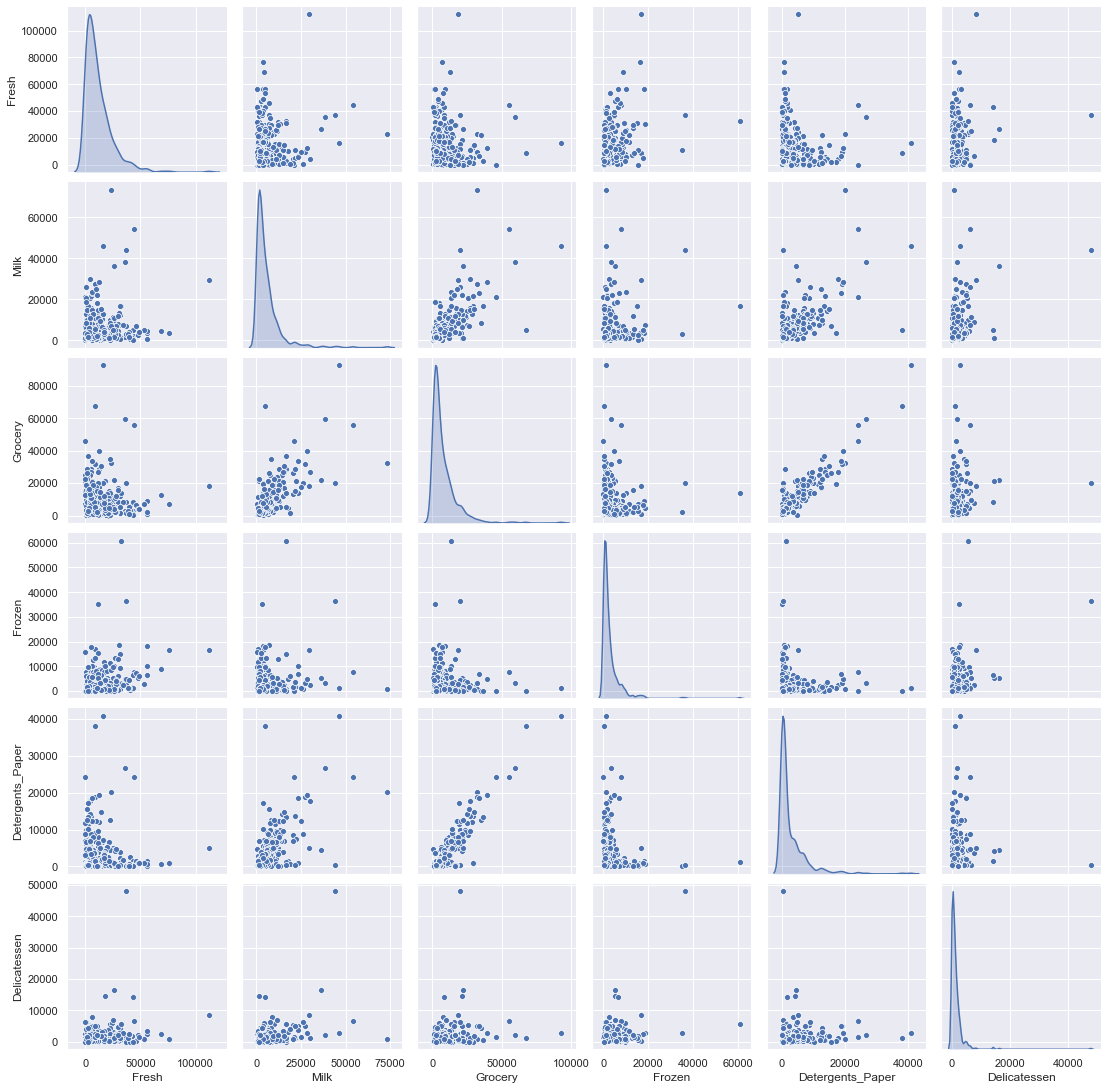

In [9]:
# Produce a scatter matrix for each pair of features in the data
sns.pairplot(data, diag_kind='kde');

### Question 3
*Are there any pairs of features which exhibit some degree of correlation? Does this confirm or deny your suspicions about the relevance of the feature you attempted to predict? How is the data for those features distributed?*  
**Hint:** Is the data normally distributed? Where do most of the data points lie? 

**Answer:** It appears that Grocery and Detergents_Paper exhibit a high degree of correlation, and to a lesser extent Grocery and Milk appear correlated. This confirms that Grocery may not be required. The data is right-skewed and not normally distributed. As stated in Answer 1, it appears there are a few very large customers.

## Data Preprocessing
In this section, you will preprocess the data to create a better representation of customers by performing a scaling on the data and detecting (and optionally removing) outliers. Preprocessing data is often times a critical step in assuring that results you obtain from your analysis are significant and meaningful.

### Implementation: Feature Scaling
If data is not normally distributed, especially if the mean and median vary significantly (indicating a large skew), it is most [often appropriate](http://econbrowser.com/archives/2014/02/use-of-logarithms-in-economics) to apply a non-linear scaling — particularly for financial data. One way to achieve this scaling is by using a [Box-Cox test](http://scipy.github.io/devdocs/generated/scipy.stats.boxcox.html), which calculates the best power transformation of the data that reduces skewness. A simpler approach which can work in most cases would be applying the natural logarithm.

In the code block below, you will need to implement the following:
 - Assign a copy of the data to `log_data` after applying a logarithm scaling. Use the `np.log` function for this.
 - Assign a copy of the sample data to `log_samples` after applying a logrithm scaling. Again, use `np.log`.

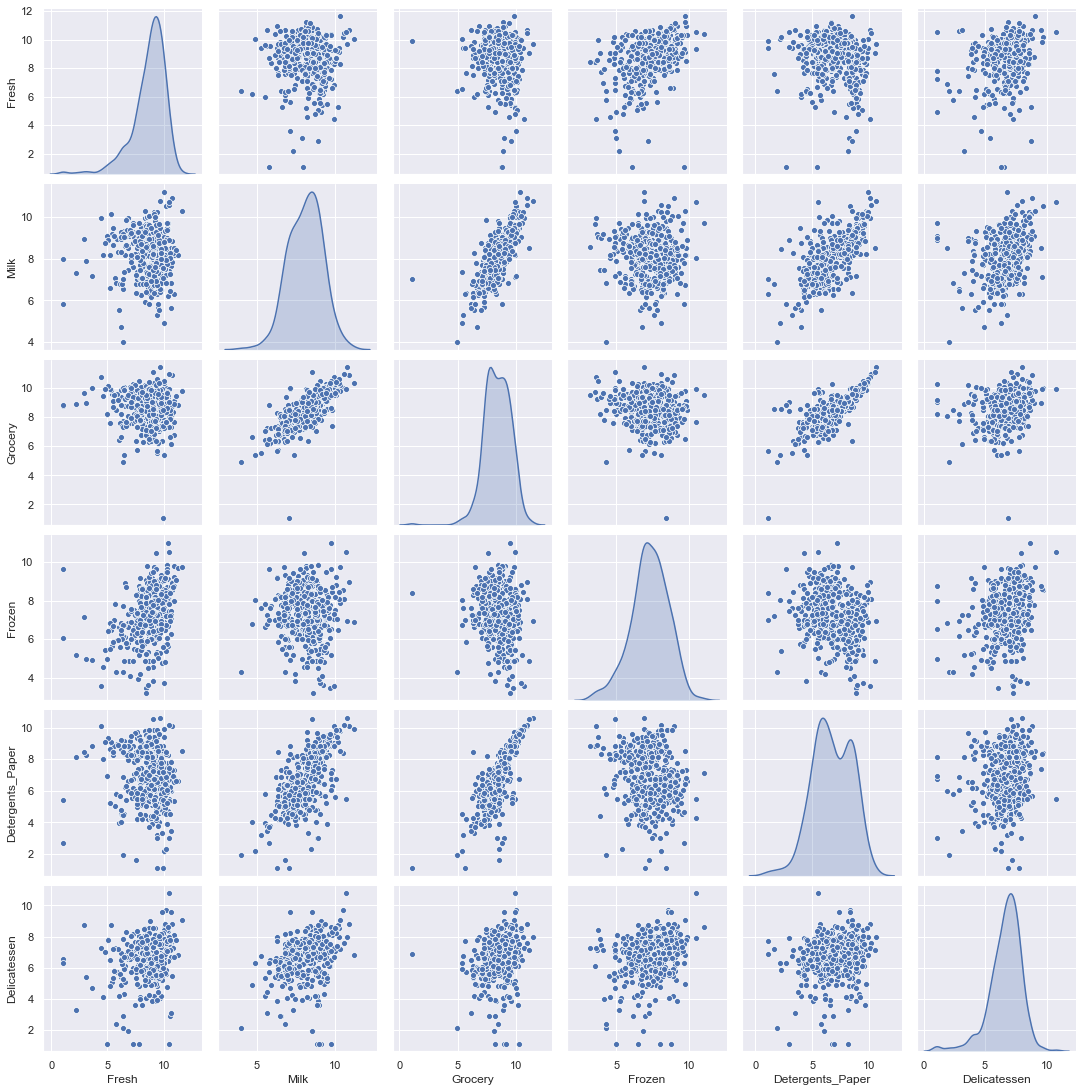

In [10]:
# TODO: Scale the data using the natural logarithm
log_data = np.log(data)

# TODO: Scale the sample data using the natural logarithm
log_samples = np.log(samples)

# Produce a scatter matrix for each pair of newly-transformed features
sns.pairplot(log_data, diag_kind='kde');

### Observation
After applying a natural logarithm scaling to the data, the distribution of each feature should appear much more normal. For any pairs of features you may have identified earlier as being correlated, observe here whether that correlation is still present (and whether it is now stronger or weaker than before).

Run the code below to see how the sample data has changed after having the natural logarithm applied to it.

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,10.180096,10.502956,9.999661,8.547528,8.374938,9.712509
1,10.675099,8.522181,9.001716,8.750208,7.364547,9.571575
2,8.028455,9.490998,10.048756,8.279190,9.206232,6.594413


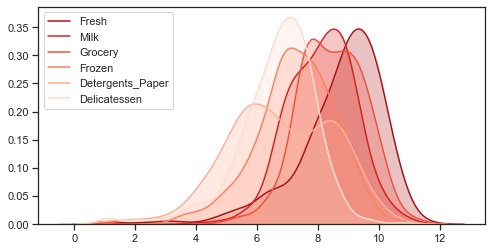

In [11]:
# Display the log-transformed sample data
display(log_samples)

# specify plot style and set color scheme
sns.set_style('ticks')
with sns.color_palette("Reds_r"):
    # plot densities of log-transformed data
    plt.figure(figsize=(8,4))
    for col in data.columns:
        sns.kdeplot(log_data[col], shade=True)
    plt.legend(loc=2);

### Implementation: Outlier Detection
Detecting outliers in the data is extremely important in the data preprocessing step of any analysis. The presence of outliers can often skew results which take into consideration these data points. There are many "rules of thumb" for what constitutes an outlier in a dataset. Here, we will use [Tukey's Method for identfying outliers](http://datapigtechnologies.com/blog/index.php/highlighting-outliers-in-your-data-with-the-tukey-method/): An *outlier step* is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal.

In the code block below, you will need to implement the following:
 - Assign the value of the 25th percentile for the given feature to `Q1`. Use `np.percentile` for this.
 - Assign the value of the 75th percentile for the given feature to `Q3`. Again, use `np.percentile`.
 - Assign the calculation of an outlier step for the given feature to `step`.
 - Optionally remove data points from the dataset by adding indices to the `outliers` list.

**NOTE:** If you choose to remove any outliers, ensure that the sample data does not contain any of these points!  
Once you have performed this implementation, the dataset will be stored in the variable `good_data`.

In [12]:
outlierct = np.array([], dtype='int64')

# For each feature find the data points with extreme high or low values
for feature in log_data.keys():
    
    # TODO: Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(log_data[feature], 25)
    
    # TODO: Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(log_data[feature], 75)
    
    # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = 1.5*(Q3-Q1)
    
    outliers = log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))]
    outlierct = np.append(outlierct, outliers.index.values.astype('int64'))
    
    # Display the outliers
    print("Data points considered outliers for the feature '{}':".format(feature))
    display(outliers)
    
outlierct, indices = np.unique(outlierct, return_inverse=True)
counts = np.bincount(indices)
multi_outliers = outlierct[counts > 1]

print(multi_outliers)

#OPTIONAL: Select the indices for data points you wish to remove
outliers  = [65,66,75,128,154]

# Remove the outliers, if any were specified
good_data = log_data.drop(log_data.index[outliers]).reset_index(drop = True)

Data points considered outliers for the feature 'Fresh':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
81,5.389072,9.163249,9.575192,5.645447,8.964184,5.049856
95,1.098612,7.979339,8.740657,6.086775,5.407172,6.563856
96,3.135494,7.869402,9.001839,4.976734,8.262043,5.379897
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
171,5.298317,10.160530,9.894245,6.478510,9.079434,8.740337
193,5.192957,8.156223,9.917982,6.865891,8.633731,6.501290
218,2.890372,8.923191,9.629380,7.158514,8.475746,8.759669
304,5.081404,8.917311,10.117510,6.424869,9.374413,7.787382


Data points considered outliers for the feature 'Milk':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
86,10.039983,11.205013,10.377047,6.894670,9.906981,6.805723
98,6.220590,4.718499,6.656727,6.796824,4.025352,4.882802
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
356,10.029503,4.897840,5.384495,8.057377,2.197225,6.306275


Data points considered outliers for the feature 'Grocery':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442


Data points considered outliers for the feature 'Frozen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
38,8.431853,9.663261,9.723703,3.496508,8.847360,6.070738
57,8.597297,9.203618,9.257892,3.637586,8.932213,7.156177
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
145,10.000569,9.034080,10.457143,3.737670,9.440738,8.396155
175,7.759187,8.967632,9.382106,3.951244,8.341887,7.436617
264,6.978214,9.177714,9.645041,4.110874,8.696176,7.142827
325,10.395650,9.728181,9.519735,11.016479,7.148346,8.632128
420,8.402007,8.569026,9.490015,3.218876,8.827321,7.239215
429,9.060331,7.467371,8.183118,3.850148,4.430817,7.824446
439,7.932721,7.437206,7.828038,4.174387,6.167516,3.951244


Data points considered outliers for the feature 'Detergents_Paper':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
161,9.428190,6.291569,5.645447,6.995766,1.098612,7.711101


Data points considered outliers for the feature 'Delicatessen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
109,7.248504,9.724899,10.274568,6.511745,6.728629,1.098612
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
137,8.034955,8.997147,9.021840,6.493754,6.580639,3.583519
142,10.519646,8.875147,9.018332,8.004700,2.995732,1.098612
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
183,10.514529,10.690808,9.911952,10.505999,5.476464,10.777768
184,5.789960,6.822197,8.457443,4.304065,5.811141,2.397895
187,7.798933,8.987447,9.192075,8.743372,8.148735,1.098612
203,6.368187,6.529419,7.703459,6.150603,6.860664,2.890372


[ 65  66  75 128 154]


### Question 4
*Are there any data points considered outliers for more than one feature based on the definition above? Should these data points be removed from the dataset? If any data points were added to the `outliers` list to be removed, explain why.* 

**Answer:**  There are several customers that are outliers in more than one category. For instance Customer[66] is an outlier in Delicatessen and Fresh categories, while Customer[75] is an outlier in the Grocery and Detergent_Paper categories. Because these outliers may disproportionately affect clustering, we will remove those customers that are outliers in two categories: 65, 66, 75, 128, and 154. This only represents 5 of the 440 total data points. After the modelling is completed, we hope to be able to see where these 5 customers might fit into one of the predicted clusters.

## Feature Transformation
In this section you will use principal component analysis (PCA) to draw conclusions about the underlying structure of the wholesale customer data. Since using PCA on a dataset calculates the dimensions which best maximize variance, we will find which compound combinations of features best describe customers.

### Implementation: PCA

Now that the data has been scaled to a more normal distribution and has had any necessary outliers removed, we can now apply PCA to the `good_data` to discover which dimensions about the data best maximize the variance of features involved. In addition to finding these dimensions, PCA will also report the *explained variance ratio* of each dimension — how much variance within the data is explained by that dimension alone. Note that a component (dimension) from PCA can be considered a new "feature" of the space, however it is a composition of the original features present in the data.

In the code block below, you will need to implement the following:
 - Import `sklearn.decomposition.PCA` and assign the results of fitting PCA in six dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of the sample log-data `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

Dimension 1    0.4430
Dimension 2    0.7068
Dimension 3    0.8299
Dimension 4    0.9311
Dimension 5    0.9796
Dimension 6    1.0000
Name: Explained Variance, dtype: float64


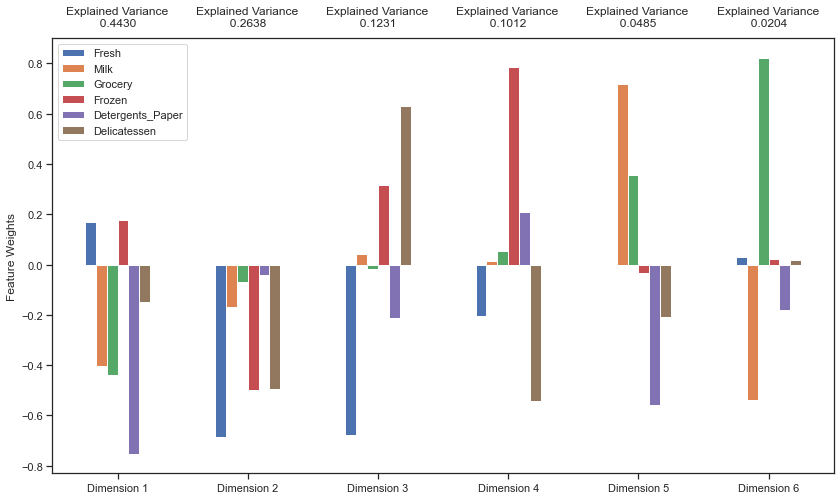

In [13]:
# TODO: Apply PCA by fitting the good data with the same number of dimensions as features
from sklearn.decomposition import PCA 
comp = PCA(n_components=6)
pca = comp.fit(good_data)

# TODO: Transform the sample log-data using the PCA fit above
pca_samples = pca.transform(log_samples)

# Generate PCA results plot
pca_results = pca_results(good_data, pca)
print(pca_results['Explained Variance'].cumsum())

### Question 5
*How much variance in the data is explained* ***in total*** *by the first and second principal component? What about the first four principal components? Using the visualization provided above, discuss what the first four dimensions best represent in terms of customer spending.*  
**Hint:** A positive increase in a specific dimension corresponds with an *increase* of the *positive-weighted* features and a *decrease* of the *negative-weighted* features. The rate of increase or decrease is based on the indivdual feature weights.

**Answer:**  The first principal component explains 44.3% of the variance in the data, while the second component explains 26.38% of the variance. Combined, those two components explain 70.68% of the variance in the data. 
- The first four components combined explain 93.11% of the variance. Using the data visualization above, the first component is negatively correlated with Detergents_Paper, Milk, and Grocery spending, while it has a slight positive correlation with Fresh and Frozen spending. This pattern might represent purchases of househould staples. 
- The second component is most highly (negatively) correlated with spending in the Fresh, Frozen, and Deli categories. This component could represent purchases for cuisine or food preparation. 
- The third component is positively correlated with spending in the Deli and Frozen categories, while being negatively correlated with spending in the Fresh category. This component could represent purchases for easy-to-prepare food. 
- The fourth component is highly correlated with spending in the Frozen category and to a lesser degree with Detergents_Paper. It also has a negative correlation with Delicatessen spending. This component may represent spending for stocking-up on essentials that don't need to be fresh and can be stored. 

### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it in six dimensions. Observe the numerical value for the first four dimensions of the sample points. Consider if this is consistent with your initial interpretation of the sample points.

In [14]:
# Display sample log-data after having a PCA transformation applied
display(pd.DataFrame(np.round(pca_samples, 4), columns = pca_results.index.values))

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6
0,-2.8096,-3.6459,1.0567,-0.5186,0.6999,-0.1811
1,-0.6778,-3.5726,0.8504,-0.6768,-0.4940,0.2702
2,-2.9903,-0.3645,0.2521,1.5653,0.1922,0.1244


### Implementation: Dimensionality Reduction
When using principal component analysis, one of the main goals is to reduce the dimensionality of the data — in effect, reducing the complexity of the problem. Dimensionality reduction comes at a cost: Fewer dimensions used implies less of the total variance in the data is being explained. Because of this, the *cumulative explained variance ratio* is extremely important for knowing how many dimensions are necessary for the problem. Additionally, if a signifiant amount of variance is explained by only two or three dimensions, the reduced data can be visualized afterwards.

In the code block below, you will need to implement the following:
 - Assign the results of fitting PCA in two dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of `good_data` using `pca.transform`, and assign the reuslts to `reduced_data`.
 - Apply a PCA transformation of the sample log-data `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

In [15]:
# TODO: Apply PCA by fitting the good data with only two dimensions
comp = PCA(n_components=2)
pca = comp.fit(good_data)

# TODO: Transform the good data using the PCA fit above
reduced_data = pca.transform(good_data)

# TODO: Transform the sample log-data using the PCA fit above
pca_samples = pca.transform(log_samples)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it using only two dimensions. Observe how the values for the first two dimensions remains unchanged when compared to a PCA transformation in six dimensions.

In [16]:
# Display sample log-data after applying PCA transformation in two dimensions
display(pd.DataFrame(np.round(pca_samples, 4), columns = ['Dimension 1', 'Dimension 2']))

,Dimension 1,Dimension 2
0,-2.8096,-3.6459
1,-0.6778,-3.5726
2,-2.9903,-0.3645


## Clustering

In this section, you will choose to use either a K-Means clustering algorithm or a Gaussian Mixture Model clustering algorithm to identify the various customer segments hidden in the data. You will then recover specific data points from the clusters to understand their significance by transforming them back into their original dimension and scale. 

### Question 6
*What are the advantages to using a K-Means clustering algorithm? What are the advantages to using a Gaussian Mixture Model clustering algorithm? Given your observations about the wholesale customer data so far, which of the two algorithms will you use and why?*

**Answer:** K-means clustering has several properties:
* Each data point is assigned to one, and only one, cluster. There is no overlap. http://www.improvedoutcomes.com/docs/WebSiteDocs/Clustering/K-Means_Clustering_Overview.htm
* It can be less computationally intensive (https://sites.google.com/site/dataclusteringalgorithms/k-means-clustering-algorithm)
* However, it assumes that variables have the same variance and that clusters are roughly the same size (http://stats.stackexchange.com/questions/133656/how-to-understand-the-drawbacks-of-k-means)

Gaussian Mixture Models have the following characteristics:
* Data points are given a probability for each cluster (http://home.deib.polimi.it/matteucc/Clustering/tutorial_html/mixture.html). This allows for inclusion of hidden variables.
* Does not assume spherical clusters likes K-means (https://en.wikipedia.org/wiki/K-means_clustering)

While K-Means is less computationally intensive, for a data set of 440 data points with 6 features, this should not restrict choice of algorithm.

One of the goals of this project is to help the wholesaler discover some insight about their customers to improve their delivery structure. Assigning each customer to a specific cluster may aid in interpretability and facilitate planning. Therefore, K-means clustering will be used for this data set and defined problem. Additionally, the centroids and predicted cluster assignments could be used as an initialization for running a Gaussian Mixture Model.

### Implementation: Creating Clusters
Depending on the problem, the number of clusters that you expect to be in the data may already be known. When the number of clusters is not known *a priori*, there is no guarantee that a given number of clusters best segments the data, since it is unclear what structure exists in the data — if any. However, we can quantify the "goodness" of a clustering by calculating each data point's *silhouette coefficient*. The [silhouette coefficient](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). Calculating the *mean* silhouette coefficient provides for a simple scoring method of a given clustering.

In the code block below, you will need to implement the following:
 - Fit a clustering algorithm to the `reduced_data` and assign it to `clusterer`.
 - Predict the cluster for each data point in `reduced_data` using `clusterer.predict` and assign them to `preds`.
 - Find the cluster centers using the algorithm's respective attribute and assign them to `centers`.
 - Predict the cluster for each sample data point in `pca_samples` and assign them `sample_preds`.
 - Import sklearn.metrics.silhouette_score and calculate the silhouette score of `reduced_data` against `preds`.
   - Assign the silhouette score to `score` and print the result.

In [17]:
# TODO: Apply your clustering algorithm of choice to the reduced data 
from sklearn.cluster import KMeans
clusterer = KMeans(n_clusters=2, random_state=123).fit(reduced_data)

# TODO: Predict the cluster for each data point
preds = clusterer.predict(reduced_data)

# TODO: Find the cluster centers
centers = clusterer.cluster_centers_

# TODO: Predict the cluster for each transformed sample data point
sample_preds = clusterer.predict(pca_samples)

# TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
from sklearn.metrics import silhouette_score
score = silhouette_score(reduced_data, preds)
print(score)

0.42628101546910835


### Question 7
*Report the silhouette score for several cluster numbers you tried. Of these, which number of clusters has the best silhouette score?* 

7 clusters: 0.36488
6 clusters: 0.36368
5 clusters: 0.35099
4 clusters: 0.3312
3 clusters: 0.39742
2 clusters: 0.42628


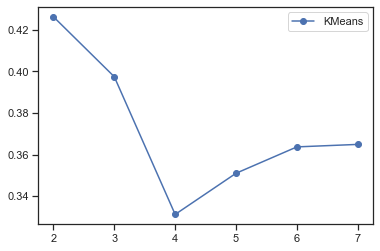

In [18]:
#code suggested by Udacity reviewer:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

#keep the scores for each cluster size
sil_scores = []
for i in range(7,1,-1):
    clusterer = KMeans(i, random_state=0).fit(reduced_data)
    preds = clusterer.predict(reduced_data)
    centers = clusterer.cluster_centers_
    sample_preds = clusterer.predict(pca_samples)
    score = silhouette_score(reduced_data, preds)

    # print the score and append to the list of scores
    print(i, 'clusters:', score.round(5))
    sil_scores.append(score)

# plot the scores
import matplotlib.pyplot as plt
plt.plot(np.arange(7,1,-1), sil_scores, '-o', label=clusterer.__class__.__name__)
plt.legend(loc='best');

**Answer:** Several different number of clusters was tried; the reported silhouette scores are presented below.

| Cluster Number (k) | Silhouette score |
|--------------------|------------------|
|         2          |     .42628       |
|         3          |     .39689       |
|         4          |     .33201       |
|         5          |     .35099       |
|         6          |     .36661       |

Of these, k=2 has the best silhouette score.

### Cluster Visualization
Once you've chosen the optimal number of clusters for your clustering algorithm using the scoring metric above, you can now visualize the results by executing the code block below. 

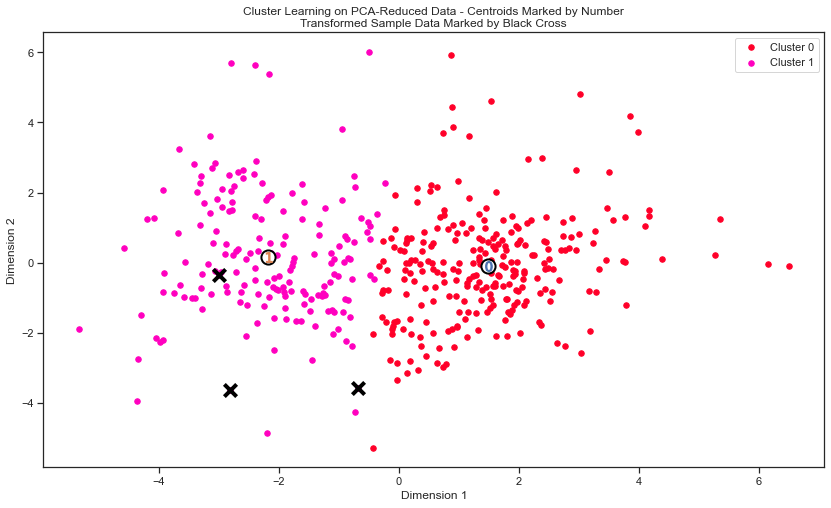

In [19]:
# Display the results of the clustering from implementation
cluster_results(reduced_data, preds, centers, pca_samples)

### Implementation: Data Recovery
Each cluster present in the visualization above has a central point. These centers (or means) are not specifically data points from the data, but rather the *averages* of all the data points predicted in the respective clusters. For the problem of creating customer segments, a cluster's center point corresponds to *the average customer of that segment*. Since the data is currently reduced in dimension and scaled by a logarithm, we can recover the representative customer spending from these data points by applying the inverse transformations.

In the code block below, you will need to implement the following:
 - Apply the inverse transform to `centers` using `pca.inverse_transform` and assign the new centers to `log_centers`.
 - Apply the inverse function of `np.log` to `log_centers` using `np.exp` and assign the true centers to `true_centers`.


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,8867.0,1897.0,2477.0,2088.0,294.0,681.0
Segment 1,4005.0,7900.0,12104.0,952.0,4561.0,1036.0


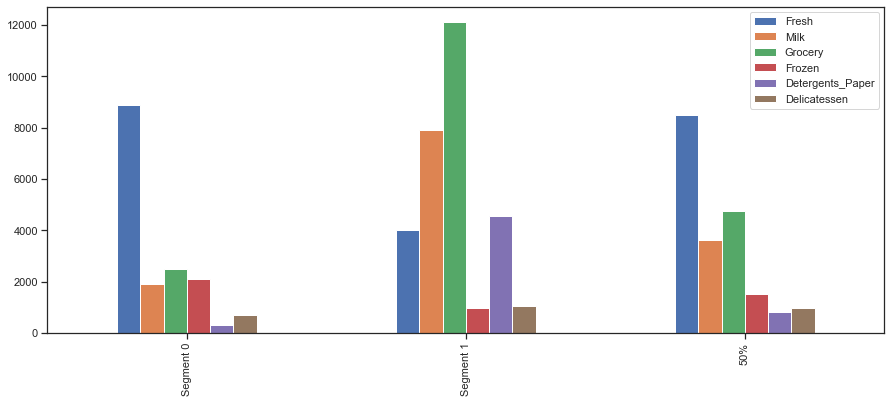

In [20]:
# TODO: Inverse transform the centers
log_centers = pca.inverse_transform(centers)

# TODO: Exponentiate the centers
true_centers = np.exp(log_centers)

# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = data.keys())
true_centers.index = segments
display(true_centers)

true_centers = true_centers.append(data.describe().loc['50%'])
_ = true_centers.plot(kind='bar', figsize=(15,6))

### Question 8
Consider the total purchase cost of each product category for the representative data points above, and reference the statistical description of the dataset at the beginning of this project. *What set of establishments could each of the customer segments represent?*  
**Hint:** A customer who is assigned to `'Cluster X'` should best identify with the establishments represented by the feature set of `'Segment X'`.

**Answer:** Segment 0 has slightly above median purchases in Fresh and Frozen categories, but relatively low purchases of Detergents_Paper and Deli. These could be restaurants. Segment 1 has higher spending for Milk, Grocery, and Detergent_Paper categories. These could be institutional buyers, like school cafeterias.

### Question 9
*For each sample point, which customer segment from* ***Question 8*** *best represents it? Are the predictions for each sample point consistent with this?*

Run the code block below to find which cluster each sample point is predicted to be.

In [21]:
# Display the predictions
for i, pred in enumerate(sample_preds):
    print("Sample point", i, "predicted to be in Cluster", pred)

Sample point 0 predicted to be in Cluster 1
Sample point 1 predicted to be in Cluster 1
Sample point 2 predicted to be in Cluster 1


**Answer:**  Based on the bar graph above which displays the centroid (cluster center) for each segment, we would predict the following:
* Sample point 0/Customer[23] - With high Milk and Fresh, and low Frozen and Detergent_Paper spending, will be in Segment 0
* Sample point 1/Customer[87] - With high Fresh and Deli, will be in Segment 0
* Sample point 2/Customer[200] - With high Grocery, Milk and Detergent_Paper spending, will be in Segment 1

The model predictions are consistent with our predictions for sample point 2, but differ for sample points 0 and 1.

## Conclusion

In this final section, you will investigate ways that you can make use of the clustered data. First, you will consider how the different groups of customers, the ***customer segments***, may be affected differently by a specific delivery scheme. Next, you will consider how giving a label to each customer (which *segment* that customer belongs to) can provide for additional features about the customer data. Finally, you will compare the ***customer segments*** to a hidden variable present in the data, to see whether the clustering identified certain relationships.

### Question 10
Companies will often run [A/B tests](https://en.wikipedia.org/wiki/A/B_testing) when making small changes to their products or services to determine whether making that change will affect its customers positively or negatively. The wholesale distributor is considering changing its delivery service from currently 5 days a week to 3 days a week. However, the distributor will only make this change in delivery service for customers that react positively. *How can the wholesale distributor use the customer segments to determine which customers, if any, would reach positively to the change in delivery service?*  
**Hint:** Can we assume the change affects all customers equally? How can we determine which group of customers it affects the most?

**Answer:** Different customers will prefer different schedules. For example, those that rely on fresh food or deli purchases would probably prefer a more frequent delivery schedule to ensure the food is at peak freshness. On the other hand, customers with more detergent/paper and grocery purchases may be amenable to a less frequent delivery. The distributor could take a subset of customers in Segment 1 and test the 3 day a week delivery schedule.

### Question 11
Additional structure is derived from originally unlabeled data when using clustering techniques. Since each customer has a ***customer segment*** it best identifies with (depending on the clustering algorithm applied), we can consider *'customer segment'* as an **engineered feature** for the data. Assume the wholesale distributor recently acquired ten new customers and each provided estimates for anticipated annual spending of each product category. Knowing these estimates, the wholesale distributor wants to classify each new customer to a ***customer segment*** to determine the most appropriate delivery service.  
*How can the wholesale distributor label the new customers using only their estimated product spending and the* ***customer segment*** *data?*  
**Hint:** A supervised learner could be used to train on the original customers. What would be the target variable?

**Answer:** Using the original spend data and the predicted customer segment as the target variable, a classifier (e.g. logistic regression) could be trained. This classifier could then be used with the new data to predict the customer segments for the new customers.

As suggest by a Udacity reviewer, K-nearest neighbors could also be used a supervised-learning classifier:

In [22]:
from sklearn.neighbors import KNeighborsClassifier

X_train, X_test, y_train, y_test = train_test_split(reduced_data, preds, test_size=0.25, random_state=42)

clf = KNeighborsClassifier(weights='distance')
clf.fit(X_train, y_train)

# Report the score for training and testing
print("Training accuracy = {:.4f}".format(clf.score(X_train, y_train)))
print("Testing accuracy = {:.4f}".format(clf.score(X_test, y_test)))

Training accuracy = 1.0000
Testing accuracy = 0.9908


### Visualizing Underlying Distributions

At the beginning of this project, it was discussed that the `'Channel'` and `'Region'` features would be excluded from the dataset so that the customer product categories were emphasized in the analysis. By reintroducing the `'Channel'` feature to the dataset, an interesting structure emerges when considering the same PCA dimensionality reduction applied earlier to the original dataset.

Run the code block below to see how each data point is labeled either `'HoReCa'` (Hotel/Restaurant/Cafe) or `'Retail'` the reduced space. In addition, you will find the sample points are circled in the plot, which will identify their labeling.

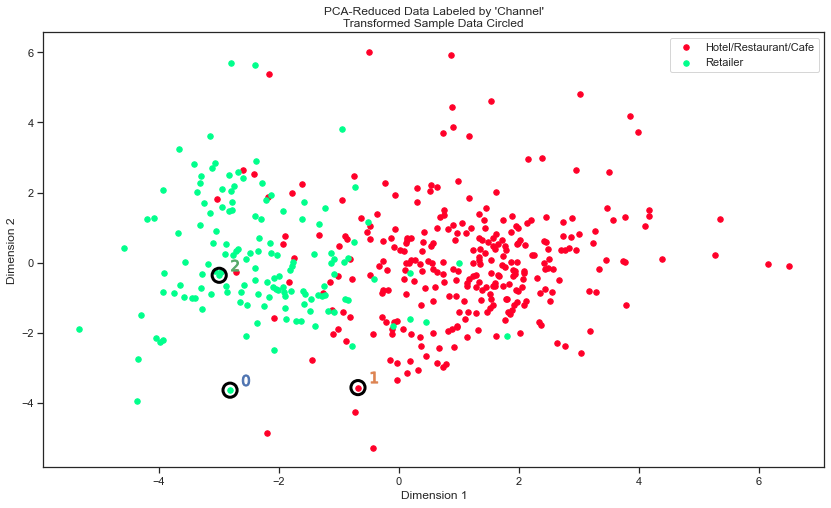

In [23]:
# Display the clustering results based on 'Channel' data
channel_results(reduced_data, outliers, pca_samples)

### Question 12
*How well does the clustering algorithm and number of clusters you've chosen compare to this underlying distribution of Hotel/Restaurant/Cafe customers to Retailer customers? Are there customer segments that would be classified as purely 'Retailers' or 'Hotels/Restaurants/Cafes' by this distribution? Would you consider these classifications as consistent with your previous definition of the customer segments?*

**Answer:**  The two clusters predicted by the k-means clustering algorithm reasonably approximate the actual distribution of hotel/restaurant/cafe and retailer customers, although there is some overlap. It appears that customers with less than 0 in both dimensions 1 and 2 are purely hotel/restaurant/cafe. These classifications are similar to my previous definitions of customer segments, although we incorrectly identified segment 1 as industrial customers as opposed to retailers.